Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from tensorflow.keras.optimizers import Adam

Data Preprocessing

In [2]:
# Data Collection
# CSV From Kaggle by Priyam Choksi
df = pd.read_csv('credit_card_transactions.csv')

# Feature engineering
df['transaction_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['transaction_time'].dt.hour
df['trans_day'] = df['transaction_time'].dt.weekday
df['trans_year'] = df['transaction_time'].dt.year
df['amt_ratio'] = df['amt'] / df.groupby('cc_num')['amt'].transform('mean')
df['daily_transaction_count'] = df.groupby(['cc_num', 'trans_day'])['trans_num'].transform('count')

# Drop unnecessary features
df = df.drop(columns=['Unnamed: 0', 'trans_date_trans_time', 'transaction_time', 'trans_num', 'first', 'last',
                      'gender', 'street', 'zip', 'city_pop', 'job', 'dob', 'unix_time', 'merch_zipcode'])

# Function to get user distance from merchant
def calc_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).miles

df['user_location_distance'] = df.apply(calc_distance, axis=1)

In [3]:
df.head()

,cc_num,merchant,category,amt,city,state,lat,long,merch_lat,merch_long,is_fraud,trans_hour,trans_day,trans_year,amt_ratio,daily_transaction_count,user_location_distance
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,36.0788,-81.1781,36.011293,-82.048315,0,0,1,2019,0.056869,250,48.947783
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,49.159047,-118.186462,0,0,1,2019,1.987606,405,18.775736
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,43.150704,-112.154481,0,0,1,2019,3.341580,69,67.172035
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,46.2306,-112.1138,47.034331,-112.561071,0,0,1,2019,0.618330,51,59.455974
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Doe Hill,VA,38.4207,-79.4629,38.674999,-78.632459,0,0,1,2019,0.440858,255,48.282030


Data Splitting

In [4]:
# Split data into training, validation, and test sets (70%, 15%, 15%)
from sklearn.model_selection import train_test_split
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 15% val and 15% test

Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Label Encoding
categorical_columns = ['merchant', 'category', 'city', 'state']
label_encoded = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])
    label_encoded[col] = le

In [6]:
print(X_train[categorical_columns].head)

<bound method NDFrame.head of         merchant  category  city  state
992821       571        11   869     17
833489       462        12   697     50
517107       687        11   347     15
166051        52         8   259     45
473161       490         6   268     25
...          ...       ...   ...    ...
110268       590         2   886     48
259178       191         9   345      6
131932       680         6   413     32
671155       409        12   318     23
121958        11        10    26     40

[907672 rows x 4 columns]>


Random Forest Model

Confusion Matrix:
[[193347     45]
 [   329    780]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193392
           1       0.95      0.70      0.81      1109

    accuracy                           1.00    194501
   macro avg       0.97      0.85      0.90    194501
weighted avg       1.00      1.00      1.00    194501


Accuracy Score:
0.9980771307088395

Precision: 0.9455
Recall: 0.7033
AUC-ROC: 0.9780


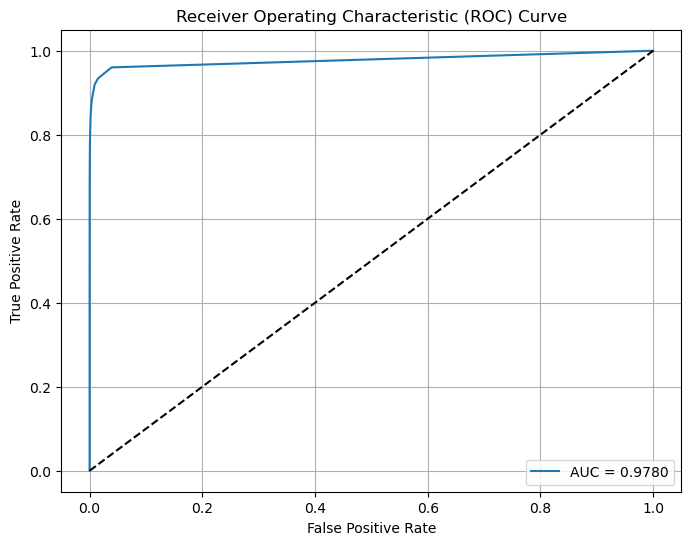

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
rf_y_val_pred = rf_model.predict(X_val)
# Get predicted probabilities for the positive class (Fraud)
rf_y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]  

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, rf_y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, rf_y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, rf_y_val_pred))

# Calculate Precision and Recall
precision = precision_score(y_val, rf_y_val_pred)
recall = recall_score(y_val, rf_y_val_pred)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_val, rf_y_val_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, rf_y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Test Set Evaluation:
Confusion Matrix:
[[193284     42]
 [   318    858]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193326
           1       0.95      0.73      0.83      1176

    accuracy                           1.00    194502
   macro avg       0.98      0.86      0.91    194502
weighted avg       1.00      1.00      1.00    194502


Accuracy Score:
0.9981491192892618

Test Precision: 0.9533
Test Recall: 0.7296
Test AUC-ROC: 0.9831


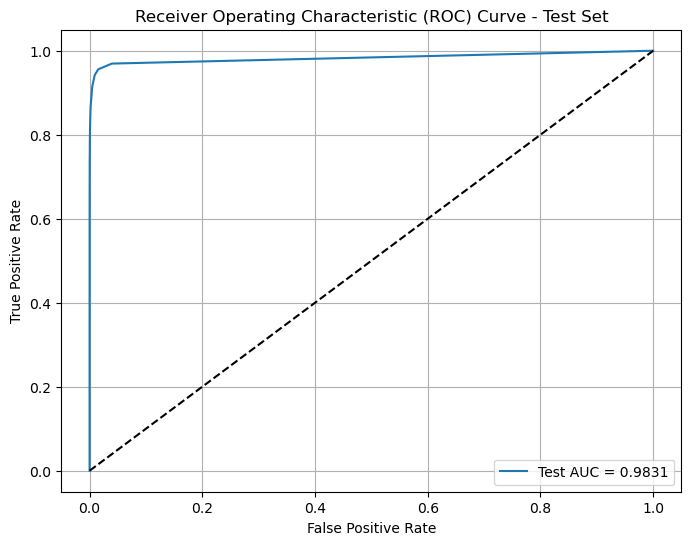

In [8]:
# Evaluate the model on the test set
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))

# Calculate Precision, Recall, and AUC-ROC for the test set
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nTest Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")

# Plot ROC Curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Feedforward Neural Network Model

In [9]:
# Standardization
scaler = StandardScaler()
numerical_features = ['cc_num', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_hour', 'trans_day', 'trans_year', 'amt_ratio', 'daily_transaction_count', 'user_location_distance']
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_val_numerical = scaler.transform(X_val[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

In [10]:
print(X_train_numerical)

[[-0.3173097  -0.43759494 -0.0091437  ... -0.43209957  3.2073634
  -1.58359749]
 [-0.31885907 -0.41084343  0.60435255 ... -0.41592014 -0.17925463
   0.49173435]
 [-0.31402512 -0.41026328  0.5933195  ... -0.39285897 -0.01492507
   0.15136119]
 ...
 [-0.31628608  0.30944908 -0.6931529  ...  0.52415954 -1.1723768
  -1.39020993]
 [-0.3189988  -0.41683835  1.99548124 ... -0.41023407 -0.55792711
   1.39486431]
 [-0.3189924   0.45422955 -0.70558478 ...  0.56623681  0.35660265
   0.05745461]]


In [11]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.subplots_adjust(wspace=0.5)

    plt.show()

Training FNN Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

# Define Embedding Dimensions
embedding_dim = {
    'merchant': 200,
    'category': 7,
    'city': 200,
    'state': 25
}

# Create Inputs and Embeddings for Each Categorical Feature
merchant_input = Input(shape=(1,), name='merchant')
merchant_embedding = Embedding(input_dim=len(label_encoded['merchant'].classes_), output_dim=embedding_dim['merchant'])(merchant_input)
merchant_embedding = Flatten()(merchant_embedding)

category_input = Input(shape=(1,), name='category')
category_embedding = Embedding(input_dim=len(label_encoded['category'].classes_), output_dim=embedding_dim['category'])(category_input)
category_embedding = Flatten()(category_embedding)

city_input = Input(shape=(1,), name='city')
city_embedding = Embedding(input_dim=len(label_encoded['city'].classes_), output_dim=embedding_dim['city'])(city_input)
city_embedding = Flatten()(city_embedding)

state_input = Input(shape=(1,), name='state')
state_embedding = Embedding(input_dim=len(label_encoded['state'].classes_), output_dim=embedding_dim['state'])(state_input)
state_embedding = Flatten()(state_embedding)

numerical_input = Input(shape=(len(numerical_features),), name='numerical_features')

# Concatenate embeddings and numerical inputs
concat_embed = Concatenate()([merchant_embedding, category_embedding, city_embedding, state_embedding])

concat_layer = Concatenate()([concat_embed, numerical_input])

# Define FNN structure
x = Dense(32, activation='relu')(concat_layer)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

fnn_model = Model(
    inputs={
        'merchant': merchant_input,
        'category': category_input,
        'city': city_input,
        'state': state_input,
        'numerical_features': numerical_input
    },
    outputs=output
)
fnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare Training and Validation Data
train_inputs = {
    'merchant': np.array(X_train['merchant']),
    'category': np.array(X_train['category']),
    'city': np.array(X_train['city']),
    'state': np.array(X_train['state']),
    'numerical_features': np.array(X_train_numerical)
}

val_inputs = {
    'merchant': np.array(X_val['merchant']),
    'category': np.array(X_val['category']),
    'city': np.array(X_val['city']),
    'state': np.array(X_val['state']),
    'numerical_features': np.array(X_val_numerical)
}

# Train model
history = fnn_model.fit(
    train_inputs, 
    np.array(y_train), 
    epochs=10, 
    batch_size=32, 
    validation_data=(val_inputs, np.array(y_val)), 
    verbose=1
)

Epoch 1/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.9956 - loss: 0.0243 - val_accuracy: 0.9970 - val_loss: 0.0139
Epoch 2/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9976 - loss: 0.0121 - val_accuracy: 0.9975 - val_loss: 0.0121
Epoch 3/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9978 - loss: 0.0107 - val_accuracy: 0.9978 - val_loss: 0.0105
Epoch 4/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9979 - loss: 0.0099 - val_accuracy: 0.9977 - val_loss: 0.0103
Epoch 5/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9980 - loss: 0.0088 - val_accuracy: 0.9978 - val_loss: 0.0108
Epoch 6/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9981 - loss: 0.0083 - val_accuracy: 0.9980 - val_loss: 0.0104
Epoch 7/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.9982 - loss: 0.0082 - val_accuracy: 0.9978 - val_loss: 0.0116
Epoch 8/10
28365/28365 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 

6079/6079 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step
Precision: 0.9233490566037735
Recall: 0.7060414788097386
AUC-ROC Score: 0.9662193634211779


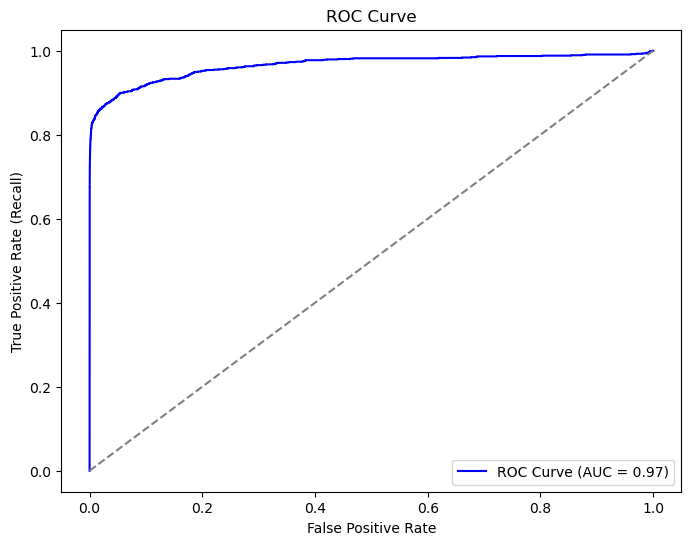

In [13]:
# Evaluate Precision, Recall, and AUC-ROC
fnn_y_pred_proba = fnn_model.predict(val_inputs).flatten()
threshold = 0.5
fnn_y_pred = (fnn_y_pred_proba >= threshold).astype(int)

fnn_precision = precision_score(y_val, fnn_y_pred)
fnn_recall = recall_score(y_val, fnn_y_pred)
fnn_auc = roc_auc_score(y_val, fnn_y_pred_proba)

print("Precision:", fnn_precision)
print("Recall:", fnn_recall)
print("AUC-ROC Score:", fnn_auc)

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, fnn_y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {fnn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

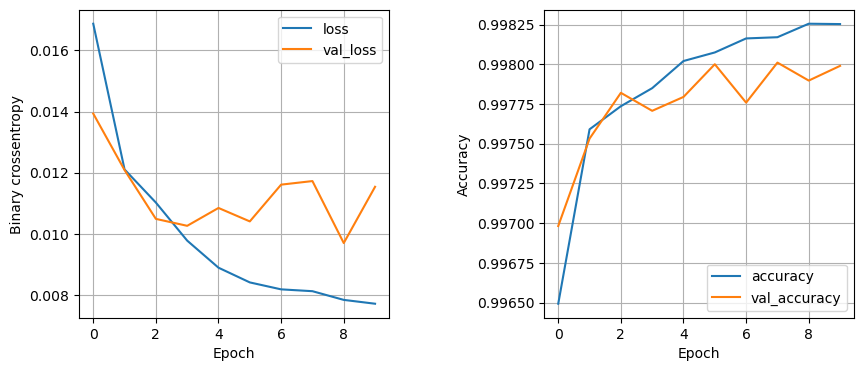

In [14]:
plot_history(history)

Logistic Regression

Validation Precision: 0.941638608305275
Validation Recall: 0.7565374211000901
Validation AUC-ROC: 0.9919600451953277
Validation Accuracy: 0.9983444815193753

Confusion Matrix:
[[193340     52]
 [   270    839]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193392
           1       0.94      0.76      0.84      1109

    accuracy                           1.00    194501
   macro avg       0.97      0.88      0.92    194501
weighted avg       1.00      1.00      1.00    194501

6079/6079 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step

Test Precision: 0.9397344228804902
Test Recall: 0.782312925170068
Test AUC-ROC: 0.9920216537418274
Test Accuracy: 0.998380479378104

Confusion Matrix (Test):
[[193267     59]
 [   256    920]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193326
           1       0.94      0.78      0.85      1176

    

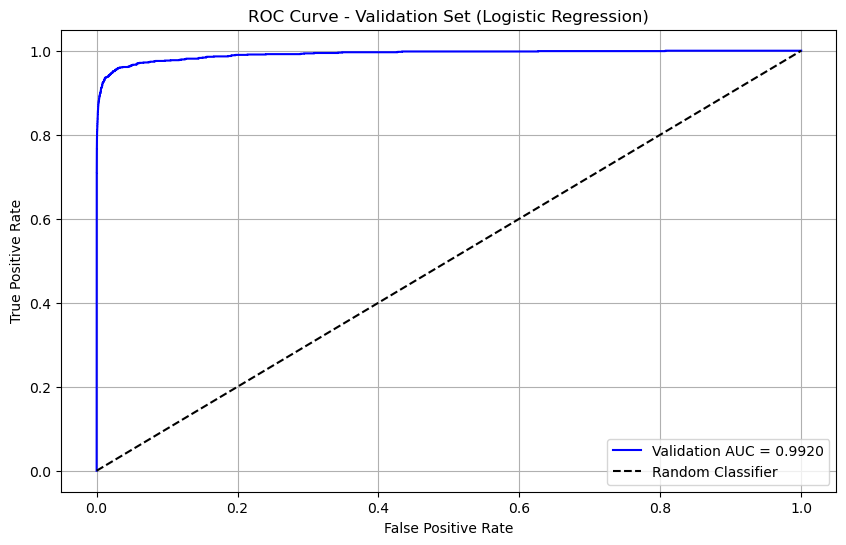

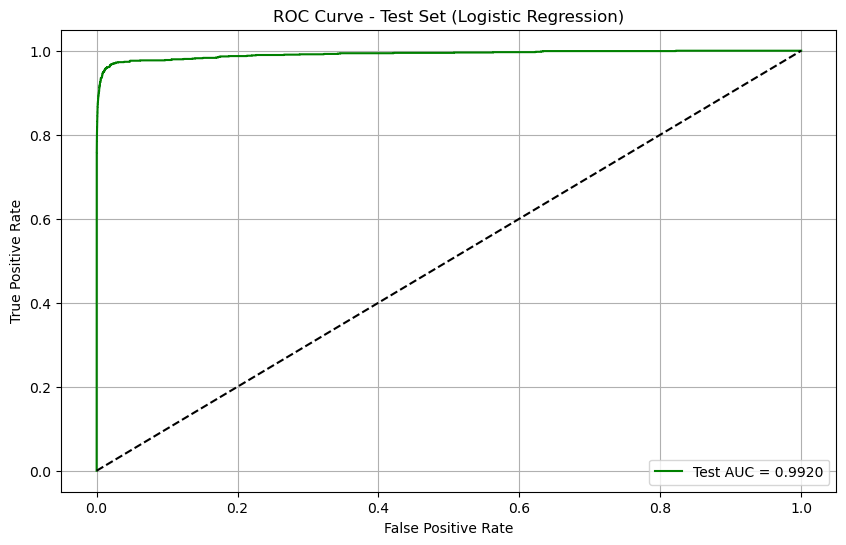

In [15]:
from sklearn.linear_model import LogisticRegression

# Combine RF and FNN predictions
combined_val_predictions = np.column_stack((rf_y_val_pred_proba, fnn_y_pred_proba))

# Define LR model
lr_model = LogisticRegression()
lr_model.fit(combined_val_predictions, y_val)

# Evaluate LR model
lr_val_pred_prob = lr_model.predict_proba(combined_val_predictions)[:, 1]
lr_val_pred = (lr_val_pred_prob >= 0.5).astype(int)

# Evaluate metrics
lr_val_precision = precision_score(y_val, lr_val_pred)
lr_val_recall = recall_score(y_val, lr_val_pred)
lr_val_auc = roc_auc_score(y_val, lr_val_pred_prob)
lr_val_accuracy = accuracy_score(y_val, lr_val_pred)

print("Validation Precision:", lr_val_precision)
print("Validation Recall:", lr_val_recall)
print("Validation AUC-ROC:", lr_val_auc)
print("Validation Accuracy:", lr_val_accuracy)
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, lr_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, lr_val_pred))

# Get predictions from both models on the test set and evaluate the Logistic Regression model
# Random Forest test predictions
rf_test_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# FNN test predictions
fnn_test_pred_prob = fnn_model.predict({
    'merchant': np.array(X_test['merchant']),
    'category': np.array(X_test['category']),
    'city': np.array(X_test['city']),
    'state': np.array(X_test['state']),
    'numerical_features': np.array(X_test_numerical)
}).flatten()

# Combine test predictions for Logistic Regression
combined_test_predictions = np.column_stack((rf_test_pred_prob, fnn_test_pred_prob))

# Evaluate on test set using Logistic Regression
lr_test_pred_prob = lr_model.predict_proba(combined_test_predictions)[:, 1]
lr_test_pred = (lr_test_pred_prob >= 0.5).astype(int)

# Test set evaluation metrics
lr_test_precision = precision_score(y_test, lr_test_pred)
lr_test_recall = recall_score(y_test, lr_test_pred)
lr_test_auc = roc_auc_score(y_test, lr_test_pred_prob)
lr_test_accuracy = accuracy_score(y_test, lr_test_pred)

print("\nTest Precision:", lr_test_precision)
print("Test Recall:", lr_test_recall)
print("Test AUC-ROC:", lr_test_auc)
print("Test Accuracy:", lr_test_accuracy)
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, lr_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, lr_test_pred))

# Plot ROC Curve for Logistic Regression on Validation Set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, lr_val_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {lr_val_auc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set (Logistic Regression)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot ROC Curve for Logistic Regression on Test Set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, lr_test_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {lr_test_auc:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (Logistic Regression)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
import joblib

# Save Random Forest
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved.")

# Save Feedforward Neural Network
fnn_model.save('fnn_model.keras')
print("FNN model saved.")

# Save Logistic Regression
joblib.dump(lr_model, 'logistic_regression_model.pkl')
print("Logistic Regression model saved.")


Random Forest model saved.
FNN model saved.
Logistic Regression model saved.
